In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Install xlrd package
%pip install xlrd

all_df = pd.read_excel('TrainDataset2024.xls', index_col=False)
all_df.drop('ID', axis=1, inplace=True)
all_df.head()

Note: you may need to restart the kernel to use updated packages.


,pCR (outcome),RelapseFreeSurvival (outcome),Age,ER,PgR,HER2,TrippleNegative,ChemoGrade,Proliferation,HistologyType,...,original_glszm_SmallAreaHighGrayLevelEmphasis,original_glszm_SmallAreaLowGrayLevelEmphasis,original_glszm_ZoneEntropy,original_glszm_ZonePercentage,original_glszm_ZoneVariance,original_ngtdm_Busyness,original_ngtdm_Coarseness,original_ngtdm_Complexity,original_ngtdm_Contrast,original_ngtdm_Strength
0,1,144.0,41.0,0,0,0,1,3,3,1,...,0.517172,0.375126,3.325332,0.002314,3880771.500,473.464852,0.000768,0.182615,0.030508,0.000758
1,0,142.0,39.0,1,1,0,0,3,3,1,...,0.444391,0.444391,3.032144,0.005612,2372009.744,59.459710,0.004383,0.032012,0.001006,0.003685
2,1,135.0,31.0,0,0,0,1,2,1,1,...,0.534549,0.534549,2.485848,0.006752,1540027.421,33.935384,0.007584,0.024062,0.000529,0.006447
3,0,12.0,35.0,0,0,0,1,3,3,1,...,0.506185,0.506185,2.606255,0.003755,6936740.794,46.859265,0.005424,0.013707,0.000178,0.004543
4,0,109.0,61.0,1,0,0,0,2,1,1,...,0.462282,0.462282,2.809279,0.006521,1265399.054,39.621023,0.006585,0.034148,0.001083,0.005626


### Data Imputer

In [2]:
from sklearn.impute import SimpleImputer

# Replace missing values with median of the column
imputer = SimpleImputer(strategy="median", missing_values=999)
all_df[:] = imputer.fit_transform(all_df)

# classification target
clf_y = all_df['pCR (outcome)']
# regression target
rgr_y = all_df['RelapseFreeSurvival (outcome)']

### Outlier Removal

In [3]:
# Outlier removal approach by:
# Thanaki, Jalaj. Machine Learning Solutions : Expert Techniques to Tackle Complex Machine Learning Problems Using Python, Packt Publishing, Limited, 2018. 
# ProQuest Ebook Central, Available at: http://ebookcentral.proquest.com/lib/nottingham/detail.action?docID=5379696.

# Outlier detection using the following methods:
# 1. Percentile based outlier detection
# 2. MAD (median absolute deviation) based outlier detection
# 3. Standard deviation based outlier detection

""" 
    Get all the data points that lie under the percentile range from 2.5 to 97.5
"""
def percentile_based_outlier(data, threshold=95):
    diff = (100 - threshold) / 2.0
    minval, maxval = np.percentile(data, [diff, 100 - diff])
    return (data < minval) | (data > maxval)

"""
    Get all the data points that lie under a threshold of 3.5 using modified Z-score (based on the median absolute deviation)
"""
def mad_based_outlier(points, threshold=3.5):
    points = np.array(points)
    if len(points.shape) == 1:
        points = points[:, None]
    median_y = np.median(points)
    median_absolute_deviation_y = np.median([np.abs(y - median_y) for y in points])
    # Small constant added to avoid division by zero
    modified_z_scores = [0.6745 * (y - median_y) / (median_absolute_deviation_y + 1e-6) for y in points]

    return np.abs(modified_z_scores) > threshold

"""
    Get all the data points that lie under a threshold of 3 using standard deviation
"""
def std_div(data, threshold=3):
    std = data.std()
    mean = data.mean()
    isOutlier = []
    for val in data:
        if abs(val - mean)/std > threshold:
            isOutlier.append(True)
        else:
            isOutlier.append(False)
    return isOutlier

"""
    Perform an outlier voting system to determine if a data point is an outlier. 
    If two of the three methods agree that a data point is an outlier, then it is removed.
"""
def outlierVote(data):
    x = percentile_based_outlier(data)
    y = mad_based_outlier(data)
    z = std_div(data)
    temp = list(zip(x, y, z))
    final = []
    for i in range(len(temp)):
        if temp[i].count(False) >= 2:
            final.append(False)
        else:
            final.append(True)
    return final

def removeOutliers(data):
    # Remove outliers from the dataframe
    for column in data.columns:
        outliers = outlierVote(all_df[column])
        # Calculate Non-Outlier Maximum using the outliers list
        non_outlier_max = all_df.loc[~np.array(outliers), column].max()
        # Replace outliers with the maximum non-outlier value
        data.loc[outliers, column] = non_outlier_max

# Remove outliers, assign modified features to X and drop the outcome columns
removeOutliers(all_df)
X = all_df.drop(['pCR (outcome)', 'RelapseFreeSurvival (outcome)'], axis=1)

### Data Normalisation/Standardisation

In [4]:
from sklearn.preprocessing import StandardScaler

# Standardise features by removing the mean and scaling to unit variance.
scaler = StandardScaler()
Xs = scaler.fit_transform(X)

### Dimensionality Reduction

1. Feature 0 (0.595337)
2. Feature 7 (0.128023)
3. Feature 4 (0.067312)
4. Feature 6 (0.054164)
5. Feature 1 (0.051488)
6. Feature 2 (0.045331)
7. Feature 5 (0.029399)
8. Feature 3 (0.028947)


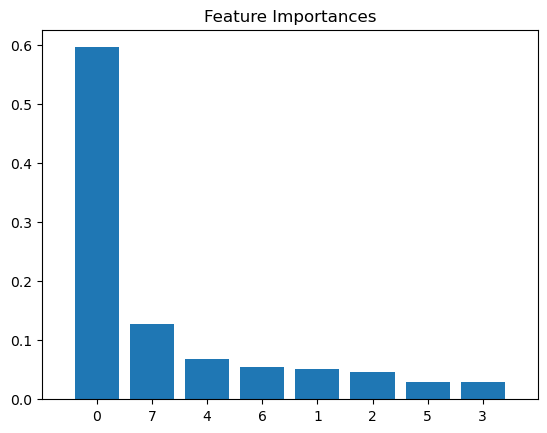

In [7]:
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler

# Normalise the features to use zero mean normalisation
scaler = StandardScaler()
Xs = scaler.fit_transform(X)

mandatory_features = ['ER', 'HER2', 'Gene']
mandatory_features_indices = [1,3,10]

x_required = Xs[:, mandatory_features_indices]
mri_indices = list(range(11, Xs.shape[1]))

X_non_required = np.delete(Xs, mri_indices, axis=1)
X_non_required = np.delete(X_non_required, mandatory_features_indices, axis=1)


# Apply LDA to all features except required ones
lda = LinearDiscriminantAnalysis(n_components=1)
Xs_lda = lda.fit_transform(mri, clf_y)

rnd_clf = RandomForestClassifier(n_estimators=1000, random_state=0, n_jobs=-1)
rnd_clf.fit(X_non_required, clf_y)
importances = rnd_clf.feature_importances_
indices = np.argsort(importances)[::-1]
for i in range(X_non_required.shape[1]):
    print("%d. Feature %d (%f)" % (i + 1, indices[i], importances[indices[i]]))

plt.title('Feature Importances')
plt.bar(range(X_non_required.shape[1]), importances[indices], align='center')
plt.xticks(range(X_non_required.shape[1]), indices)
plt.xlim([-1, X_non_required.shape[1]])
plt.show()

X_non_required_selected = X_non_required[:, indices[:4]]

# Combine required features with LDA transformed features
Xs = np.hstack((x_required, Xs_lda, X_non_required_selected))


### SVM for Classification

In [8]:
from numpy._core.fromnumeric import mean
from sklearn.svm import SVC
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from numpy import std
from sklearn.model_selection import train_test_split

# this nested cross-validation is used to tune the hyperparameters of the model
# the code was adapted from: 
# Brownlee, J. (2018). Nested Cross-Validation for Machine Learning with Python. [online] Machine Learning Mastery.
# Available at: https://machinelearningmastery.com/nested-cross-validation-for-machine-learning-with-python/ [Accessed 5 Dec. 2024]

# configure the cross-validation procedure for the inner loop
cv_inner = KFold(n_splits=5, shuffle=True, random_state=2)

# define the classifier
classifier = SVC(random_state=2)

# define search space of hyperparameters
space = dict()
space['C'] = [0.1, 1, 10]
space['gamma'] = [0.01, 0.1]
space['kernel'] = ["rbf", "linear", "poly"]

# define GridSearch to search for the best hyperparameters
search = GridSearchCV(classifier, space, scoring='accuracy', n_jobs=1, cv=cv_inner, refit=True)

# configure the cross-validation procedure for the outer loop
cv_outer = KFold(n_splits=5, shuffle=True, random_state=2)

# execute the nested cross-validation
scores = cross_val_score(search, Xs, clf_y, scoring='accuracy', cv=cv_outer, n_jobs=-1)

# fit the search on the whole dataset to get the best model
search.fit(Xs, clf_y)
model = search.best_estimator_

# report performance and best model configuration
print('Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))
print('Best Model:', model)

from sklearn.metrics import classification_report

# Print f1-score, precision, recall and support
y_pred = model.predict(Xs)
print(classification_report(clf_y, y_pred))

Accuracy: 0.845 (0.052)
Best Model: SVC(C=10, gamma=0.01, random_state=2)
              precision    recall  f1-score   support

           0       0.91      0.96      0.93       316
           1       0.82      0.63      0.71        84

    accuracy                           0.89       400
   macro avg       0.86      0.80      0.82       400
weighted avg       0.89      0.89      0.89       400



In [9]:
from numpy import mean, std
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

from sklearn.ensemble import RandomForestClassifier

# configure the cross-validation procedure
cv_inner = KFold(n_splits=5, shuffle=True, random_state=1)
# define the model
model = RandomForestClassifier(random_state=1)
# define search space
space = dict()
space['n_estimators'] = [10, 100, 500]
space['max_features'] = [2, 4, 6]
# define search
search = GridSearchCV(model, space, scoring='accuracy', n_jobs=1, cv=cv_inner, refit=True)
# configure the cross-validation procedure
cv_outer = KFold(n_splits=5, shuffle=True, random_state=1)
# execute the nested cross-validation
scores = cross_val_score(search, Xs, clf_y, scoring='accuracy', cv=cv_outer, n_jobs=-1)
# fit the search on the whole dataset to get the best model
search.fit(Xs, clf_y)
best_model = search.best_estimator_
# report performance
print('Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))
print('Best Model:', best_model)

# Print f1-score, precision, recall and support
y_pred = model.predict(Xs)
print(classification_report(clf_y, y_pred))

Accuracy: 0.838 (0.025)
Best Model: RandomForestClassifier(max_features=4, n_estimators=500, random_state=1)


NotFittedError: This RandomForestClassifier instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [ ]:
from sklearn.linear_model import LogisticRegression

# configure the cross-validation procedure
cv_inner = KFold(n_splits=5, shuffle=True, random_state=1)
# define the model
model = LogisticRegression(random_state=1)
# define search space
space = dict()
space['C'] = [0.1, 1, 10, 100]
# define search
search = GridSearchCV(model, space, scoring='accuracy', n_jobs=1, cv=cv_inner, refit=True)
# configure the cross-validation procedure
cv_outer = KFold(n_splits=5, shuffle=True, random_state=1)
# execute the nested cross-validation
scores = cross_val_score(search, Xs, clf_y, scoring='accuracy', cv=cv_outer, n_jobs=-1)
# fit the search on the whole dataset to get the best model
search.fit(Xs, clf_y)
best_model = search.best_estimator_
# report performance
print('Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))
print('Best Model:', best_model)

Accuracy: 0.792 (0.024)
Best Model: LogisticRegression(C=10, random_state=1)


In [ ]:
from sklearn.neural_network import MLPClassifier

mlp_pCR = MLPClassifier(random_state=1, max_iter=1000)
kfold = KFold(n_splits=5, shuffle=True, random_state=1)
cv_scores_pCR = cross_val_score(mlp_pCR, Xs, clf_y, cv=kfold, scoring='balanced_accuracy')
print(f'Balanced Accuracy for PCR (cross-validated): {cv_scores_pCR.mean()} ± {cv_scores_pCR.std()}')

/opt/anaconda3/envs/MLE/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/envs/MLE/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/envs/MLE/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/envs/MLE/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Balanced Accuracy for PCR (cross-validated): 0.6094590053763441 ± 0.021335278216603762


/opt/anaconda3/envs/MLE/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


In [ ]:
from sklearn.neighbors import KNeighborsClassifier

# configure the cross-validation procedure
cv_inner = KFold(n_splits=5, shuffle=True, random_state=1)
# define the model
model = KNeighborsClassifier()
# define search space
space = dict()
space['n_neighbors'] = [1, 5, 10, 15, 20]
space['metric'] = ['euclidean', 'manhattan', 'minkowski']
# define search
search = GridSearchCV(model, space, scoring='accuracy', n_jobs=1, cv=cv_inner, refit=True)
# configure the cross-validation procedure
cv_outer = KFold(n_splits=5, shuffle=True, random_state=1)
# execute the nested cross-validation
scores = cross_val_score(search, Xs, clf_y, scoring='accuracy', cv=cv_outer, n_jobs=-1)
# fit the search on the whole dataset to get the best model
search.fit(Xs, clf_y)
best_model = search.best_estimator_
# report performance
print('Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))
print('Best Model:', best_model)

/opt/anaconda3/envs/MLE/lib/python3.10/site-packages/numpy/ma/core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,
/opt/anaconda3/envs/MLE/lib/python3.10/site-packages/numpy/ma/core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Accuracy: 0.795 (0.017)
Best Model: KNeighborsClassifier(metric='euclidean')


### Saving the model

In [ ]:
import joblib

#joblib.dump({"model": model, "scaler": scaler, "lda": lda}, 'pcr_classification_model.joblib')